In [1]:
%matplotlib inline
%load_ext lab_black

nb_samples = 30
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
nb_features = len(list_features)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from traffic.core import Traffic
from artefact import Autoencoder
from artefact.clustering import get_latent
from artefact.training import train
from artefact.plot import plot_loss, plot_latent, plot_latent_and_trajs

t = Traffic.from_file("data/lszh.parquet")
X = np.load("data/lszh.npy")
model_ = Autoencoder((nb_samples * nb_features, 32, 8, 2))
device = 0

/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:294: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance(name, collections.Sequence):


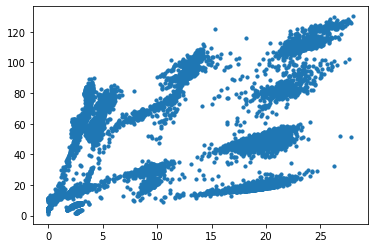

In [3]:
model, loss = train(
    model_, X, device=device, nb_iterations=10000, batch_size=len(X), lambda_kl=0
)
torch.save(model.state_dict(), "models/ae_10000.pth")
plot_latent(X, model, device)

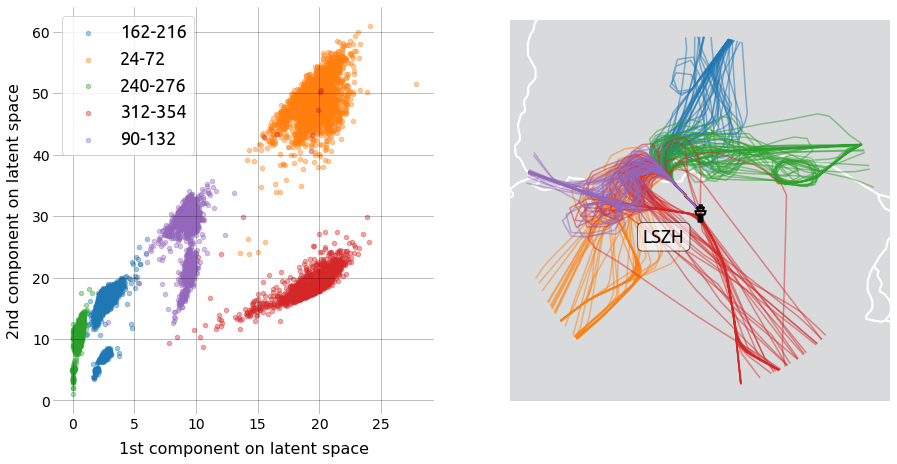

In [4]:
model.load_state_dict(torch.load("models/ae_10000.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, "figs/latent_ae.png", runway=14)

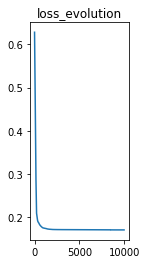

In [5]:
plot_loss(loss["loss"])

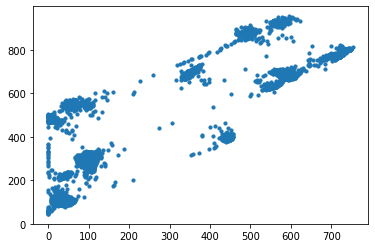

In [6]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.05
)
torch.save(model.state_dict(), "models/tsne_500_005.pth")
plot_latent(X, model, device)

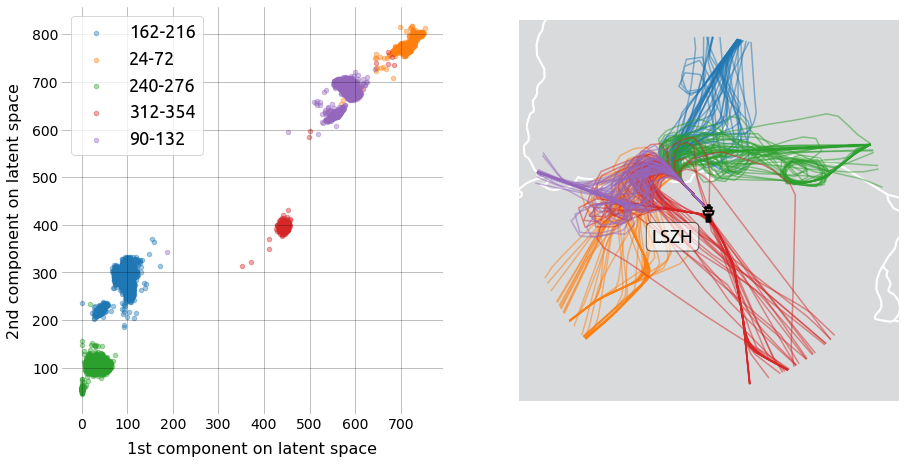

In [8]:
model.load_state_dict(torch.load("models/tsne_500_005.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, "figs/latent_tsne_500_005.png", runway=14)

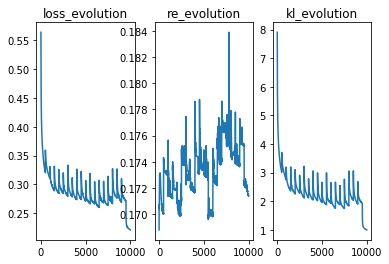

In [7]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

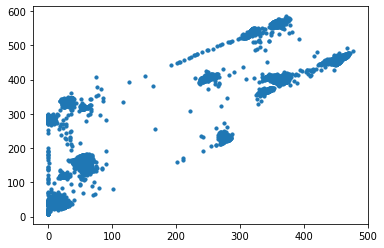

In [9]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.01
)
torch.save(model.state_dict(), "models/tsne_500_001.pth")
plot_latent(X, model, device)

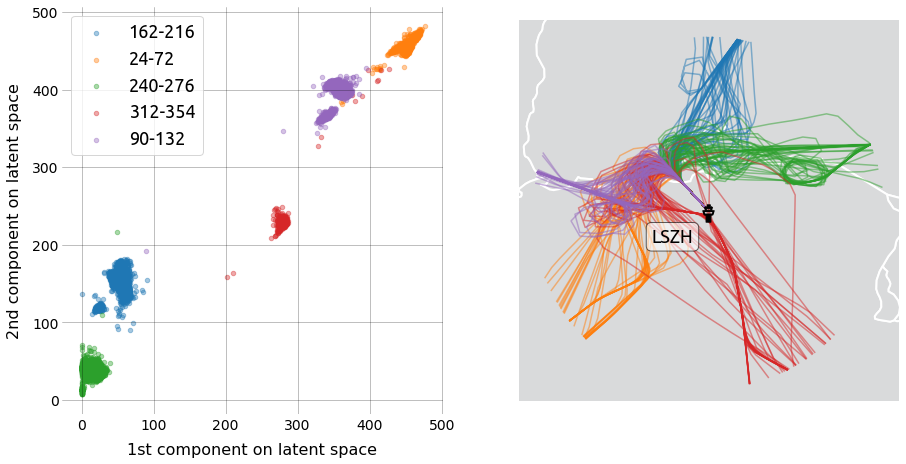

In [10]:
model.load_state_dict(torch.load("models/tsne_500_001.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, "figs/latent_tsne_500_001.png", runway=14)

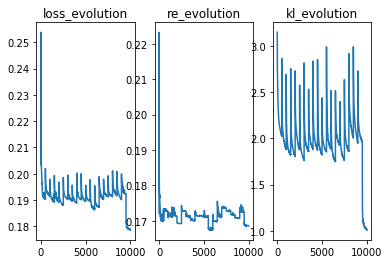

In [11]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

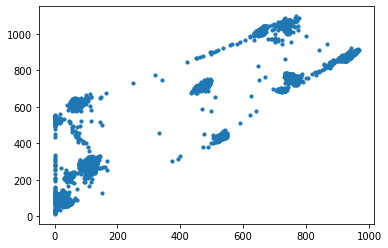

In [12]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.07
)
torch.save(model.state_dict(), "models/tsne_500_007.pth")
plot_latent(X, model, device)

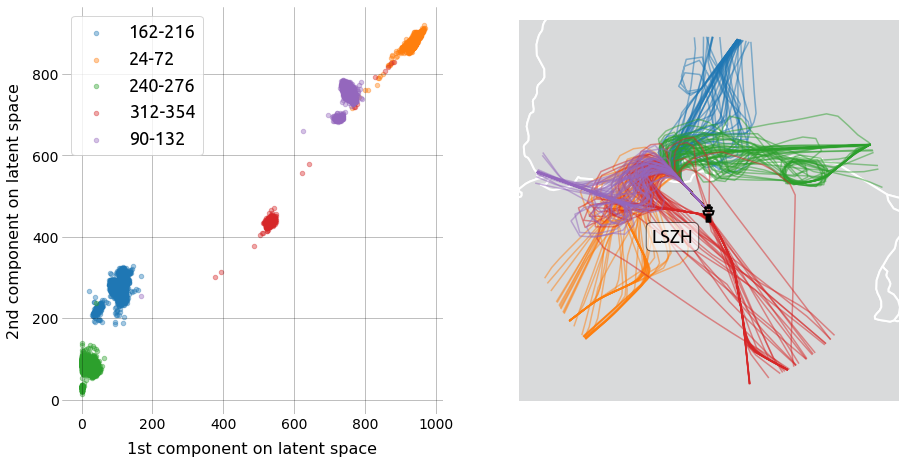

In [13]:
model.load_state_dict(torch.load("models/tsne_500_007.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, "figs/latent_tsne.png", runway=14)

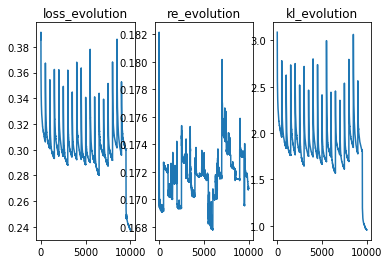

In [14]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

from traffic.core import Traffic

from artefact import AutoencoderTSNE, Autoencoder

t = Traffic.from_file("data/lszh.parquet")
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
# list_features = ["longitude", "latitude"]

nb_flights = len(t)
nb_samples = len(t[0])
nb_features = len(list_features)
lambda_kl = 0.07
print(f"nb_flights: {len(t)}")

device = 1

algo_clustering = AutoencoderTSNE(
    gpu=device,
    batch_size=1000,
    model=Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    lambda_kl=lambda_kl,
    nb_iterations=500,
    algo_clustering=DBSCAN(eps=0.05, min_samples=20),
    distance_trajectory="euclidean",  # delta_max
    savedir=".",
)
model = algo_clustering.model

t_tsne = t.clustering(
    nb_samples=None,
    features=list_features,
    clustering=algo_clustering,
    transform=MinMaxScaler(feature_range=(-1, 1)),
).fit_predict()

t_tsne.to_pickle("test/t_tsne.pkl")
t_tsne.groupby(["cluster"]).agg({"flight_id": "nunique"})

nb_flights: 19457


,flight_id
cluster,
-1,14901
0,834
1,366
2,1210
3,606
4,20
5,1002
6,41
7,13


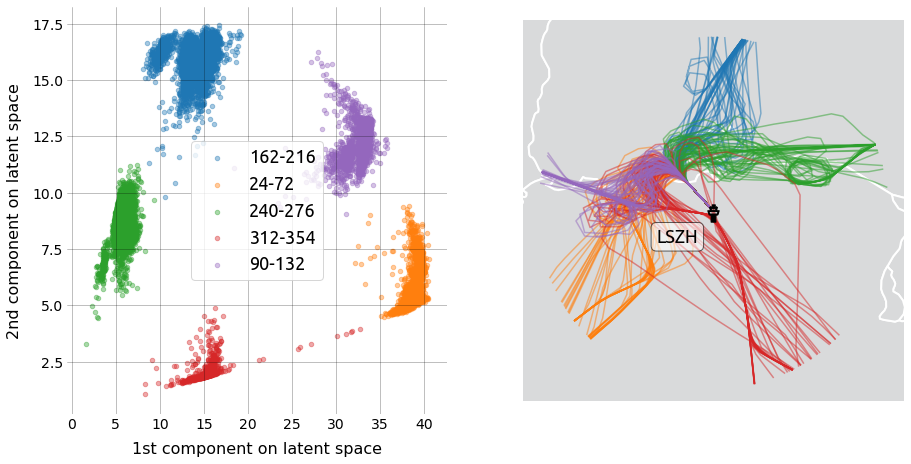

In [16]:
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(t, algo_clustering.get_latent(), "figs/latent.png", runway=14)

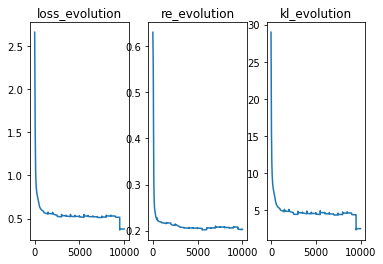

In [17]:
from artefact.plot import plot_loss

loss = algo_clustering.loss
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

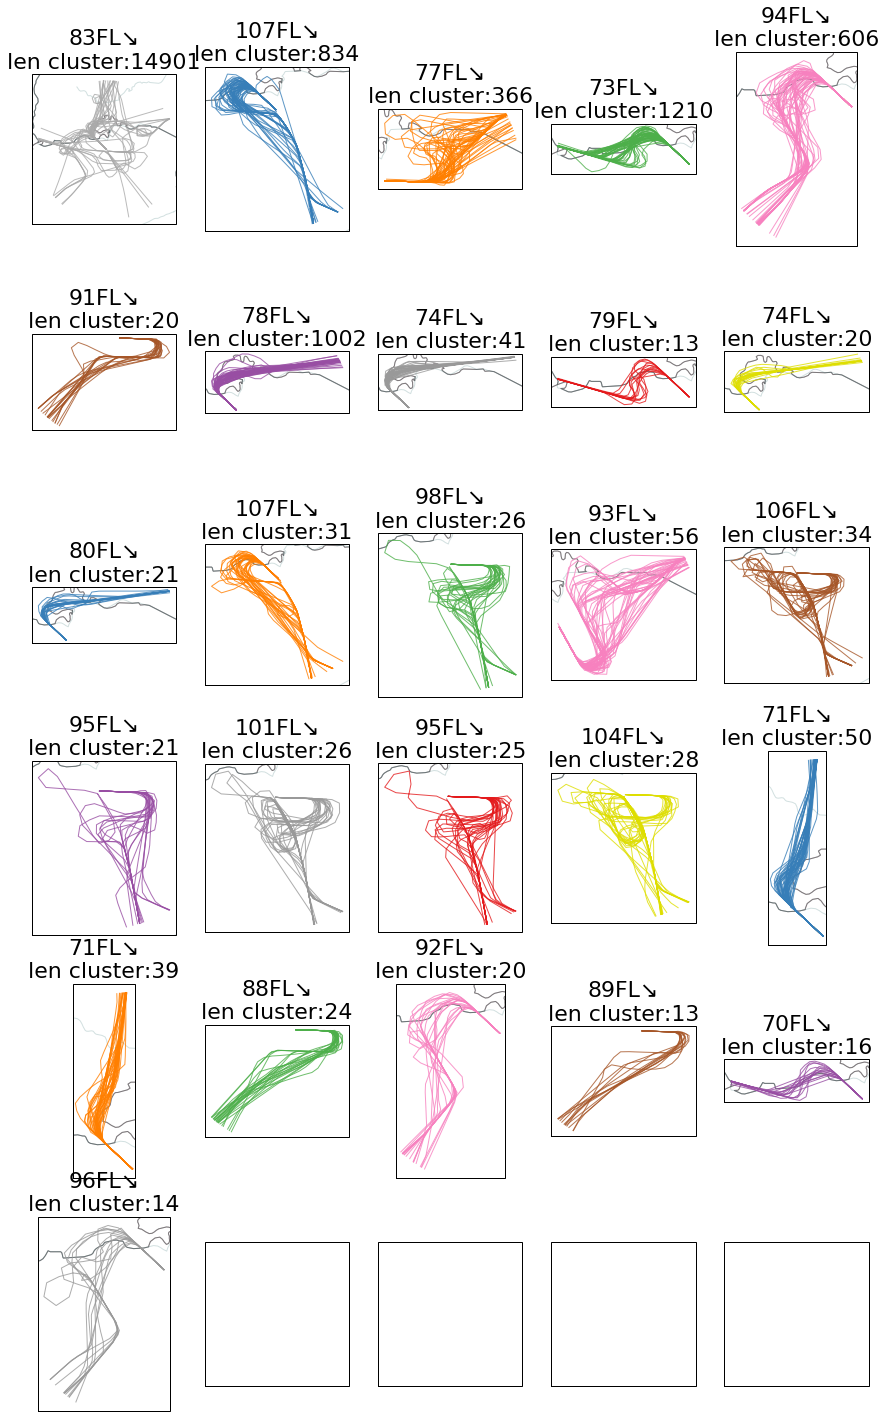

In [18]:
from traffic.core import Traffic
from artefact.plot import plot_trajs

t_tsne = Traffic.from_file("test/t_tsne.pkl")
plot_trajs(t_tsne, None)

In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from traffic.core import Traffic
from artefact import AutoencoderTSNE, Autoencoder

def pretrained_clust(algo_clustering, pretrained_path, to_pickle):
    t = Traffic.from_file("data/lszh.parquet")
    list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
    nb_samples = len(t[0])
    nb_features = len(list_features)

    algo_clustering = AutoencoderTSNE(
        gpu=1,
        model=Autoencoder((nb_samples * nb_features, 32, 8, 2)),
        pretrained_path=pretrained_path,        
        algo_clustering=algo_clustering,
    )

    # X = np.load("data/lszh.npy")
    # algo_clustering.fit(X)
    t_tsne = t.clustering(
        nb_samples=None,
        features=list_features,
        clustering=algo_clustering,
        transform=MinMaxScaler(feature_range=(-1, 1)),
    ).fit_predict()

    t_tsne.to_pickle(to_pickle)
    print(t_tsne.groupby(["cluster"]).agg({"flight_id": "nunique"}))
    return t_tsne

         flight_id
cluster           
-1             468
 0            1734
 1            2037
 2            1275
 3             990
 4            3118
 5            4434
 6            1139
 7             728
 8            3491
 9              43


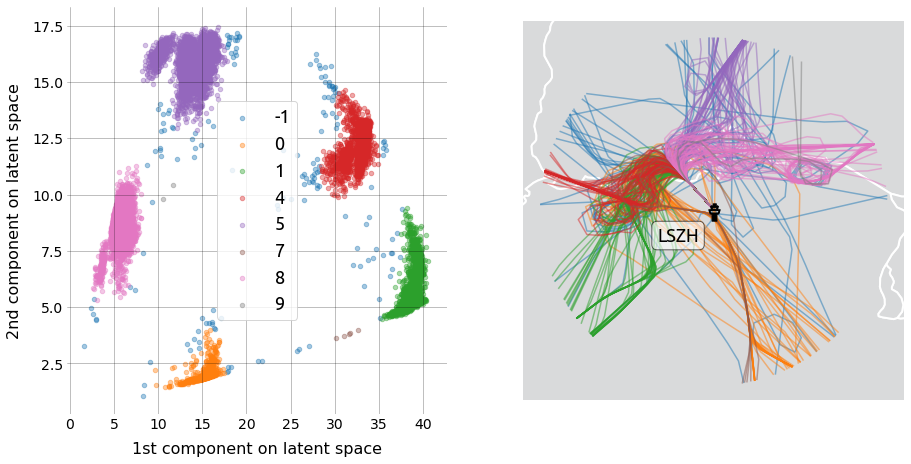

In [20]:
t_tsne = pretrained_clust(DBSCAN(eps=0.7, min_samples=30), "models/model.pth", "test/t_tsne_dbscan.pkl")
from artefact.plot import plot_latent_and_trajs
plot_latent_and_trajs(t_tsne, algo_clustering.get_latent(), "figs/latent_clusters_dbscan_07_30.png", plot_clusters=True, runway=14)

         flight_id
cluster           
-1             631
 0            1726
 1            2032
 2            1266
 3             966
 4            3086
 5            4422
 6            1125
 7             725
 8            3478


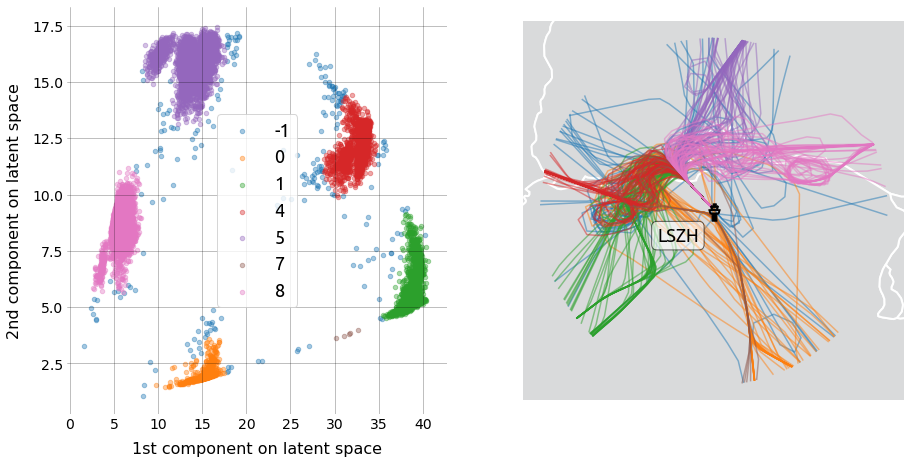

In [19]:
t_tsne = pretrained_clust(DBSCAN(eps=0.6, min_samples=30), "models/model.pth", "test/t_tsne_dbscan.pkl")
from artefact.plot import plot_latent_and_trajs
plot_latent_and_trajs(t_tsne, algo_clustering.get_latent(), "figs/latent_clusters_dbscan_06_30.png", plot_clusters=True, runway=14)

         flight_id
cluster           
0             4797
1             5239
2             4413
3             3132
4             1876


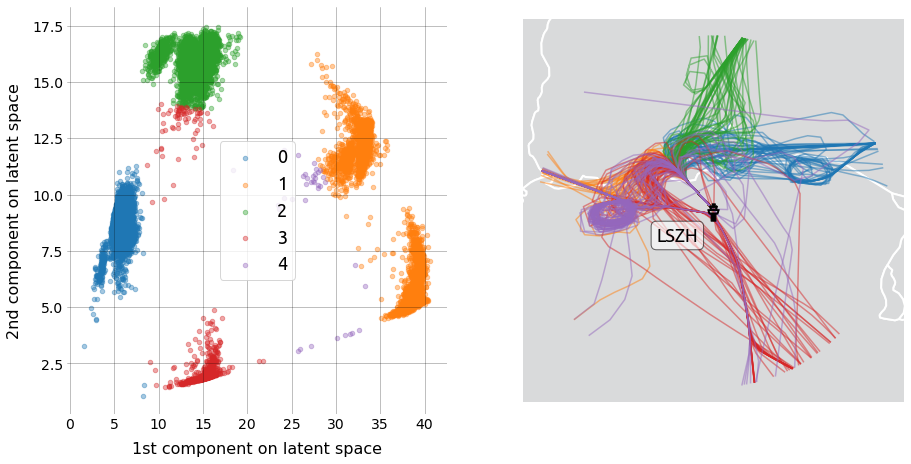

In [15]:
t_tsne = pretrained_clust(GaussianMixture(n_components=5), "models/model.pth", "test/t_tsne_gm.pkl")
from artefact.plot import plot_latent_and_trajs
plot_latent_and_trajs(t_tsne, algo_clustering.get_latent(), "figs/latent_clusters_gm.png", plot_clusters=True, runway=14)